![Banner](./img/AI_Special_Program_Banner.jpg)

# Exercises for Ensemble Learning
---
The exercises are strongly oriented towards the lecture material and can often be solved with minor adaptations of the same.

## Data preparation

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In this exercise we want to deal with glass: [Glass Identification Data Set](http://archive.ics.uci.edu/ml/datasets/Glass+Identification). This is about the classification of different types of glass based on the oxide compounds.

In [2]:
col_names = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Target']
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data', names=col_names)
df.head()

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Target
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Remove the ID column (is only a surrogate key):

In [3]:
df.drop('Id', axis=1, inplace=True)

The data contains 7 different classes, which can be roughly divided into window glass and non-window glass. Since we want to consider a binary classification, we assign the superordinate categories accordingly:

In [4]:
map_target = {1 : 0, # building_windows_float_processed
              2 : 0, # building_windows_non_float_processed
              3 : 0, # vehicle_windows_float_processed
              4 : 0, # vehicle_windows_non_float_processed (none in this database)
              5 : 1, # containers
              6 : 1, # tableware
              7 : 1} # headlamps

In [5]:
df['Target'] = df['Target'].map(map_target)

Derive the feature matrix `X` and label vector `y`:

In [6]:
y = df.pop('Target')
X = df.copy()

Division of the data into training and test data. In addition, scaling of the data.

**Note:** We do this exactly in this order to avoid *data leakage*. You can find more information on this in this [article by Jason Brownlee](https://machinelearningmastery.com/data-leakage-machine-learning/) and this [blog post by Sebastian Raschka](https://sebastianraschka.com/faq/docs/scale-training-test.html).

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # sklearn.cross_validation has been superseded

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.25, 
                        stratify=y,
                        random_state=1)

sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [8]:
print(f'There are {X_train_std.shape[0]} training data and {X_test_std.shape[0]} test data.')

There are 160 training data and 54 test data.


<h1 style="color:blue">Exercises</h1>

---

<h2 style="color:blue">Task 1 - Select the most important features</h2>

* Select the two most important features based on the `feature_importances_` of a decision tree
* Use the configuration below for the decision tree
* Which features have been selected?
* List all features and their feature importances. Which features do not contribute to the classification?
* Save the new feature matrices under `X_train_rel` and `X_test_rel` for further use

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(max_depth=3, 
                                criterion='gini', 
                                random_state=0)

### Answer

In [10]:
clf_dt.fit(X_train_std,y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [11]:
fi = clf_dt.feature_importances_

In [12]:
rel_col_idx = fi.argsort()[-2:][::-1]

Which features were selected?

In [13]:
df.columns[rel_col_idx]

Index(['Mg', 'RI'], dtype='object')

In [14]:
X_train_rel = X_train_std[:,rel_col_idx]
X_test_rel = X_test_std[:,rel_col_idx]

In [15]:
print(f'The most important feature is {df.columns[rel_col_idx][0]}, the second most important feature is {df.columns[rel_col_idx][1]}')

The most important feature is Mg, the second most important feature is RI


All features and their importance

In [16]:
for i,x in enumerate(clf_dt.feature_importances_):
    print(df.columns[i], x)

RI 0.18325881470516353
Na 0.057466677308643944
Mg 0.6737138108086569
Al 0.016555876081775993
Si 0.0
K 0.0
Ca 0.0
Ba 0.0690048210957596
Fe 0.0


Thus, the features Si, K, Ca and Fe do not contribute to the classification.

Finally, we can check the dimension of the new characteristic matrices:

In [17]:
X_train_rel.shape

(160, 2)

In [18]:
X_test_rel.shape

(54, 2)

**Comments**
1. One might think that it is not really necessary to select the most important features based only on the subset of data we want to use for training, as this is only a pre-processing step and the actual models are created afterwards. However, a form of *data leakage* (see above) could be argued if we use all available data.

2. In our particular case, experimentation shows that if we split into training and test data differently, we might get different features (e.g. try setting the `random_state` to 42 instead of 1 for the split). This is related to a warning given in the `scikit-learn` documentation for the `feature_importances_` property for the [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_), as we have more or less different values in the individual columns everywhere. Therefore, it might make more sense to try [permutation importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) for the feature selection here.

<h2 style="color:blue">Task 2 - Create and cross-validate a voting classifier</h2>

1. Use the following base classifiers:
    1. *Perceptron*, with a maximum of 50 iterations, a tolerance of $10^{-3}$ and `random_state=0`
    2. [*Gaussian Naive Bayes*](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) with the default settings
    3. *Logistic regression* with the default settings (`random_state=0`)
2. Use Hard Voting
3. Since we are considering unevenly distributed classes here, you should use the [Balanced Accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score) and the F1 score as scoring criteria.

In [19]:
from sklearn.model_selection import cross_val_score # sklearn.cross_validation has been superseded
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

import numpy as np

clf_p = Perceptron(max_iter=50, tol=0.001, random_state=0)

clf_nb = GaussianNB()

clf_lr = LogisticRegression(random_state=0)

clf_mv = VotingClassifier(estimators=[('p',clf_p), ('NB',clf_nb), ('LR',clf_lr)], voting='hard')

clf_labels = ['Perceptron', 'NB', 'LR', 'Majority Voting']

all_clf = [clf_p, clf_nb, clf_lr, clf_mv]

f1_scorer = make_scorer(f1_score)
balacc_scorer = make_scorer(balanced_accuracy_score)

scorers = [balacc_scorer, f1_scorer]
scorer_labels = ['Balanced Accuracy','F1-Score']

print('10-fold (stratified) cross validation:\n')
for scorer, sclabel in zip(scorers, scorer_labels):
    for clf, label in zip(all_clf, clf_labels):
        scores = cross_val_score(estimator=clf, 
                                 X=X_train_rel, 
                                 y=y_train, 
                                 cv=10, 
                                 scoring=scorer) 
#                                  scoring='accuracy') 
        print(f'{sclabel}: {scores.mean():0.3f} (+/- {scores.std():0.3f}) [{label}])')

10-fold (stratified) cross validation:

Balanced Accuracy: 0.854 (+/- 0.128) [Perceptron])
Balanced Accuracy: 0.817 (+/- 0.159) [NB])
Balanced Accuracy: 0.863 (+/- 0.132) [LR])
Balanced Accuracy: 0.863 (+/- 0.132) [Majority Voting])
F1-Score: 0.788 (+/- 0.195) [Perceptron])
F1-Score: 0.741 (+/- 0.228) [NB])
F1-Score: 0.813 (+/- 0.204) [LR])
F1-Score: 0.813 (+/- 0.204) [Majority Voting])


Interestingly, the logistic regression performs just as well as the ensemble.

In addition, the ranking of the classifiers for both performance metrics *Balanced Accuracy* and *F1-Score* is identical.

<h2 style="color:blue">Task 3 - Plot the decision areas of the ensemble and the base classifiers</h2>

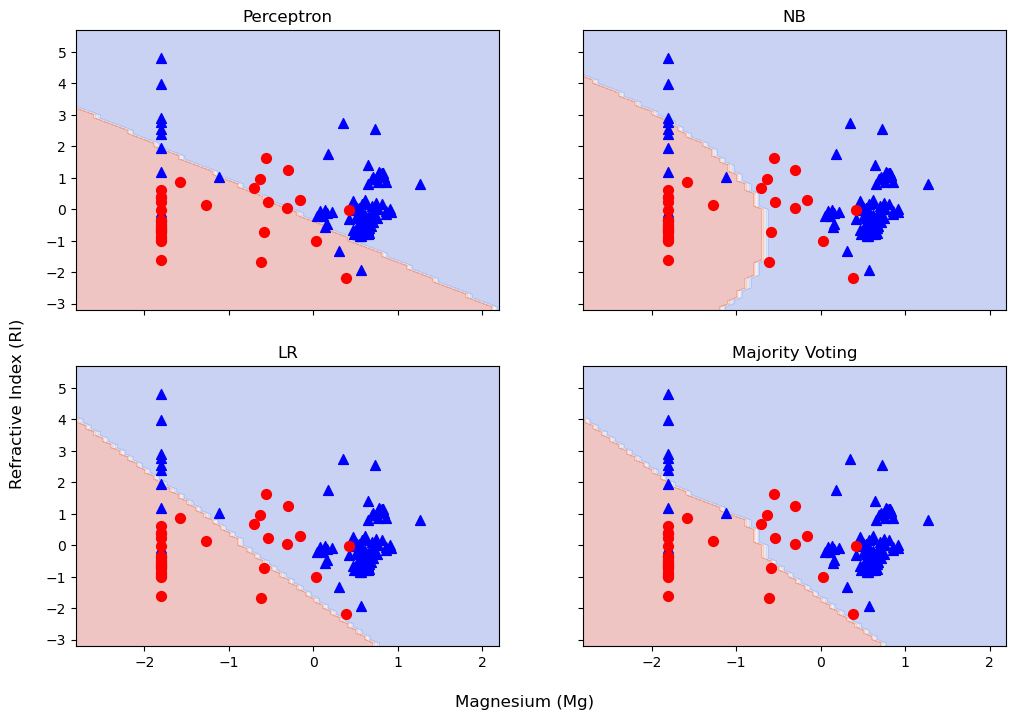

In [20]:
from itertools import product

x_min = X_train_rel[:, 0].min() - 1
x_max = X_train_rel[:, 0].max() + 1
y_min = X_train_rel[:, 1].min() - 1
y_max = X_train_rel[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(12, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_rel, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_rel[y_train==0, 0], 
                                  X_train_rel[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_rel[y_train==1, 0], 
                                  X_train_rel[y_train==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.0, 
         s='Magnesium (Mg)', 
         ha='center', va='center', fontsize=12)
plt.text(-9.5, 4.5, 
         s='Refractive Index (RI)', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

# plt.tight_layout()
# plt.savefig('./figures/voting_panel', bbox_inches='tight', dpi=300)
plt.show()

<h2 style="color:blue">Task 4 - Check which parameters can be adjusted for the voting classifier</h2>

In [21]:
clf_mv.get_params()

{'estimators': [('p', Perceptron(max_iter=50)),
  ('NB', GaussianNB()),
  ('LR', LogisticRegression(random_state=0))],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'hard',
 'weights': None,
 'p': Perceptron(max_iter=50),
 'NB': GaussianNB(),
 'LR': LogisticRegression(random_state=0),
 'p__alpha': 0.0001,
 'p__class_weight': None,
 'p__early_stopping': False,
 'p__eta0': 1.0,
 'p__fit_intercept': True,
 'p__l1_ratio': 0.15,
 'p__max_iter': 50,
 'p__n_iter_no_change': 5,
 'p__n_jobs': None,
 'p__penalty': None,
 'p__random_state': 0,
 'p__shuffle': True,
 'p__tol': 0.001,
 'p__validation_fraction': 0.1,
 'p__verbose': 0,
 'p__warm_start': False,
 'NB__priors': None,
 'NB__var_smoothing': 1e-09,
 'LR__C': 1.0,
 'LR__class_weight': None,
 'LR__dual': False,
 'LR__fit_intercept': True,
 'LR__intercept_scaling': 1,
 'LR__l1_ratio': None,
 'LR__max_iter': 100,
 'LR__multi_class': 'auto',
 'LR__n_jobs': None,
 'LR__penalty': 'l2',
 'LR__random_state': 0,
 'LR__sol

<h2 style="color:blue">Task 5 - Use Grid Search to investigate the effect of using class weights</h2>

* To do this, examine the `class_weight` parameter in the *perceptron* and the *logistic regression*
* Use the balanced accuracy as a metric

In [22]:
from sklearn.model_selection import GridSearchCV  # grid_search is now also part of model selection

params = {'p__class_weight': [None,'balanced'],
          'LR__class_weight': [None,'balanced']}

grid = GridSearchCV(estimator=clf_mv, 
                    param_grid=params, 
                    cv=10, 
#                    scoring='balanced_accuracy')
                    scoring=balacc_scorer)
grid.fit(X_train_rel, y_train)

grid_scores = zip(grid.cv_results_['params'],
                  grid.cv_results_['mean_test_score'],
                  grid.cv_results_['std_test_score'])

for params, mean_score, std_score in grid_scores:
    print(f'Balanced accuracy: {mean_score:.3f}+/-{std_score:.2f} {params}')

Balanced accuracy: 0.863+/-0.13 {'LR__class_weight': None, 'p__class_weight': None}
Balanced accuracy: 0.854+/-0.13 {'LR__class_weight': None, 'p__class_weight': 'balanced'}
Balanced accuracy: 0.854+/-0.15 {'LR__class_weight': 'balanced', 'p__class_weight': None}
Balanced accuracy: 0.879+/-0.16 {'LR__class_weight': 'balanced', 'p__class_weight': 'balanced'}


In [23]:
print(f'Best parameters: {grid.best_params_}')
print(f'Balanced accuracy: {grid.best_score_:.3f}')

Best parameters: {'LR__class_weight': 'balanced', 'p__class_weight': 'balanced'}
Balanced accuracy: 0.879


By using weighted parameter updates, the balanced accuracy can actually be increased. Interestingly, this is only true if both the logistic regression and the perceptron work with weighted classes. If only one of the models uses `class_weight='balanced'`, then we get a worse balanced accuracy than in the unbalanced case.

<h2 style="color:blue">Task 6 - Train an Adaboost classifier with a perceptron as base classifier and a random forest and compare their respective accuracies (also with the base classifier)</h2>

* Use the *Balanced Accuracy* metric again
* Use the same settings for the perceptron as in task 2
* Since the perceptron does not provide class probabilities as output, you must set `algorithm='SAMME'` for Adaboost. Otherwise, use the same parameters as in the lecture material
* For the random forest, you can select the same parameters as in the lecture materials

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

perc = Perceptron(tol=0.001, random_state=0)

ada = AdaBoostClassifier(estimator=perc,
                         algorithm='SAMME',
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=0)

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10, 
                                random_state=0,
                                n_jobs=2)

for clf, tt in zip([perc, ada, forest],
                    ['Perceptron', 'AdaBoost', 'Random Forest']):
    clf = clf.fit(X_train_rel, y_train)
    y_train_pred = clf.predict(X_train_rel)
    y_test_pred = clf.predict(X_test_rel)

    clf_train = balanced_accuracy_score(y_train, y_train_pred)
    clf_test = balanced_accuracy_score(y_test, y_test_pred)
    print(f'{tt} train/test balanced accuracy {clf_train:.3f}/{clf_test:.3f}')

Perceptron train/test balanced accuracy 0.892/0.872
AdaBoost train/test balanced accuracy 0.893/0.834
Random Forest train/test balanced accuracy 0.996/0.886


Interestingly, the perceptron and Adaboost achieve approximately the same results, although the perceptron seems to generalize better. The Random Forest achieves the best results, but may suffer from overfitting.

<h2 style="color:blue">Task 7 - Plot the decision regions of the classifiers just created</h2>

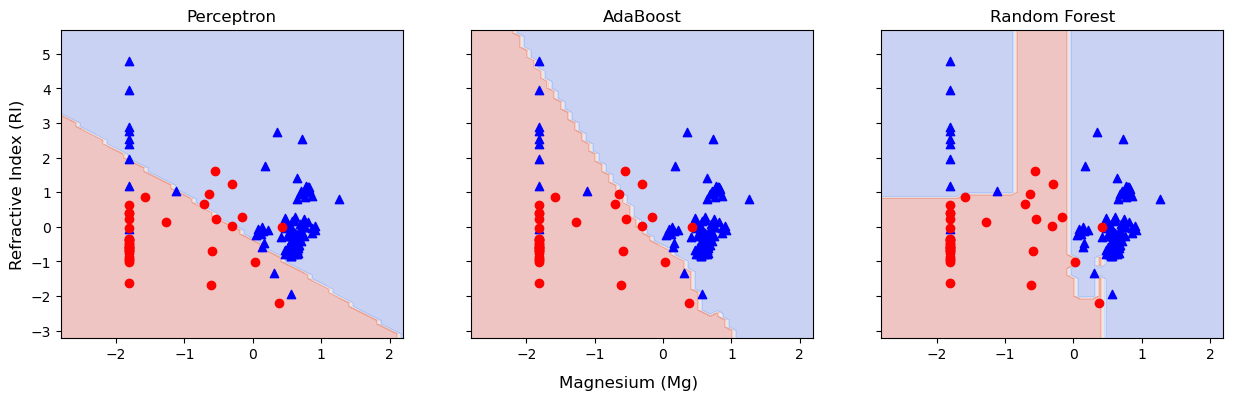

In [25]:
x_min = X_train_rel[:, 0].min() - 1
x_max = X_train_rel[:, 0].max() + 1
y_min = X_train_rel[:, 1].min() - 1
y_max = X_train_rel[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=3, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(15, 4))


for idx, clf, tt in zip([0, 1, 2],
                        [perc, ada, forest],
                        ['Perceptron', 'AdaBoost', 'Random Forest']):
    clf.fit(X_train_rel, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)
    axarr[idx].scatter(X_train_rel[y_train==0, 0], 
                       X_train_rel[y_train==0, 1], 
                       c='blue', marker='^')
    
    axarr[idx].scatter(X_train_rel[y_train==1, 0], 
                       X_train_rel[y_train==1, 1], 
                       c='red', marker='o')
    
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Refractive Index (RI)', fontsize=12)
plt.text(-6.5, -4.5, 
         s='Magnesium (Mg)', 
         ha='center', va='center', fontsize=12)
plt.show()

From this visualization, we can guess that the random forest is indeed overfitting, which is indicated by the small "knobs" sticking out to the right of the red decision area. However, the model has also correctly identified the middle corridor and thus perhaps adapted the underlying distribution of this data set better than the other models. In any case, more data would certainly help to obtain a clearer picture of the situation.